In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Multiply, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import os

In [2]:
# Function to preprocess TIFF images
def preprocess_tiff(image_path, target_size, bands=[4, 3, 2], normalize=True):
    with rasterio.open(image_path) as src:
        bands_data = [src.read(band) for band in bands]
        rgb_image = np.dstack(bands_data)
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)
        if normalize:
            rgb_image = np.clip(rgb_image, 0, 255) / 255.0  # Normalize to 0 to 1
    return rgb_image

# Function to load and preprocess standard images
def load_image(image_path, target_size=(1054, 1054), normalize=True):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    if normalize:
        image = image / 255.0  # Normalize to 0 to 1
    return image

In [3]:
# Generator class for data loading
class DataGenerator(Sequence):
    def __init__(self, hr_image_files, lr_dir='lr_images', hr_dir='hr_images', lc_dir='resized_lc_images', batch_size=16, target_size=(1054, 1054)):
        self.hr_image_files = hr_image_files
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lc_dir = lc_dir
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.hr_image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_hr_files = self.hr_image_files[index * self.batch_size:(index + 1) * self.batch_size]
        hr_images, lr_images = [], []
        
        for hr_file in batch_hr_files:
            hr_image_path = os.path.join(self.hr_dir, hr_file)
            base_name = hr_file.replace('_rgb.png', '')
            
            hr_image = load_image(hr_image_path)
            lr_image_file = f"{base_name}-L2A_data.tiff"
            lr_image_path = os.path.join(self.lr_dir, lr_image_file)
            lr_image = preprocess_tiff(lr_image_path, self.target_size)
            
            lc_image_file = f"{base_name}_dynamic_world_label.tif"
            lc_image_path = os.path.join(self.lc_dir, lc_image_file)
            with rasterio.open(lc_image_path) as src:
                lc_band = src.read(1)
                lc_band = cv2.resize(lc_band, self.target_size, interpolation=cv2.INTER_CUBIC)
                lc_band = np.expand_dims(lc_band, axis=-1)
                lc_band = np.clip(lc_band, 0, 255) / 255.0
            
            # Combine LC band with LR and HR images
            lr_image = np.concatenate((np.clip(lr_image, 0, 1), lc_band), axis=-1)
            hr_image = np.concatenate((np.clip(hr_image, 0, 1), lc_band), axis=-1)
            
            hr_splits = self.split_image(hr_image, (527, 527))
            lr_splits = self.split_image(lr_image, (527, 527))
            
            hr_images.extend(hr_splits)
            lr_images.extend(lr_splits)
        
        return np.array(lr_images), np.array(hr_images)

    def split_image(self, image, size=(527, 527)):
        h, w = image.shape[:2]
        split_images = []
        for i in range(0, h, size[0]):
            for j in range(0, w, size[1]):
                split_img = image[i:i + size[0], j:j + size[1]]
                split_images.append(split_img)
        return split_images

# Split the list of HR image filenames into training and testing sets
hr_image_files = [f for f in os.listdir('hr_images') if f.endswith('_rgb.png') and not f.startswith('.')]
train_files, test_files = train_test_split(hr_image_files, test_size=0.2, random_state=42)

# Initialize the data generators
train_generator = DataGenerator(train_files)
test_generator = DataGenerator(test_files)

In [4]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(1, 1, input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1, 1, 1, input_shape[-1]), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        attention = K.tanh(K.conv2d(x, self.W) + self.b)
        attention_weights = K.softmax(attention, axis=-1)
        context_vector = attention_weights * x
        return context_vector


In [5]:
# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Create SRCNN model with attention mechanism
def create_model_with_attention(input_shape=(527, 527, 4)):  # 4 channels: RGB + landcover band
    inputs = Input(shape=input_shape)
    attention = AttentionLayer()(inputs)
    
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(attention)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = Conv2D(4, (5, 5), activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', psnr_metric, ssim_metric])
    return model

model = create_model_with_attention()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 527, 527, 4)]     0         
                                                                 
 attention_layer (AttentionL  (None, 527, 527, 4)      20        
 ayer)                                                           
                                                                 
 conv2d (Conv2D)             (None, 527, 527, 64)      20800     
                                                                 
 conv2d_1 (Conv2D)           (None, 527, 527, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 527, 527, 4)       3204      
                                                                 
Total params: 26,104
Trainable params: 26,104
Non-trainable params: 0
_________________________________________________________

In [6]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_with_attention_high_psnr.h5', save_best_only=True, monitor='val_loss')


In [7]:
# Train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, accuracy, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Test PSNR: {psnr}, Test SSIM: {ssim}")

# Save the final model
model.save('srcnn_with_attention_high_psnr.h5')

/home/zhou.hanyi/.local/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/20
43/43 [==============================] - 2669s 62s/step - loss: 0.0033 - mse: 0.0033 - psnr_metric: 26.0109 - ssim_metric: 0.6550 - val_loss: 0.0029 - val_mse: 0.0029 - val_psnr_metric: 26.2161 - val_ssim_metric: 0.6914
Epoch 2/20
43/43 [==============================] - 2720s 63s/step - loss: 0.0028 - mse: 0.0028 - psnr_metric: 26.5511 - ssim_metric: 0.7266 - val_loss: 0.0029 - val_mse: 0.0029 - val_psnr_metric: 26.3367 - val_ssim_metric: 0.7166
Epoch 3/20
43/43 [==============================] - 2730s 64s/step - loss: 0.0027 - mse: 0.0027 - psnr_metric: 26.5744 - ssim_metric: 0.7219 - val_loss: 0.0028 - val_mse: 0.0028 - val_psnr_metric: 26.4001 - val_ssim_metric: 0.6854
Epoch 4/20
43/43 [==============================] - 2699s 63s/step - loss: 0.0027 - mse: 0.0027 - psnr_metric: 26.7065 - ssim_metric: 0.7272 - val_loss: 0.0028 - val_mse: 0.0028 - val_psnr_metric: 26.5965 - val_ssim_metric: 0.7224
Epoch 5/20
43/43 [==============================] - 2704s 63s/step - loss: 0

In [8]:
# Evaluate the model on the test set
test_loss, test_mse, test_psnr, test_ssim = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")

11/11 [==============================] - 128s 11s/step - loss: 0.0021 - mse: 0.0021 - psnr_metric: 28.0517 - ssim_metric: 0.7677
Test Loss: 0.002137315459549427
Test MSE: 0.0021373156923800707
Test PSNR: 28.051666259765625
Test SSIM: 0.7677319645881653


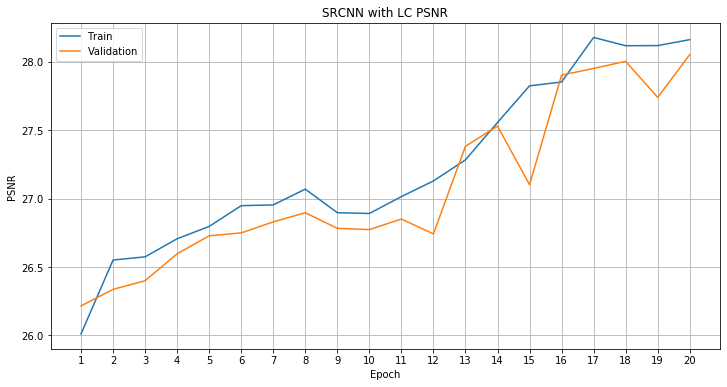

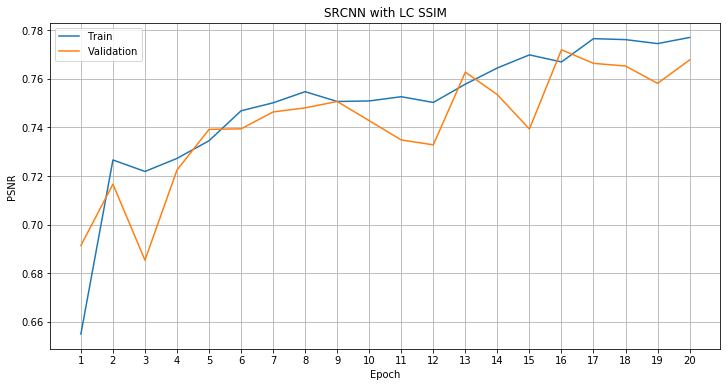

In [91]:
# Plot training & validation PSNR values
plt.figure(figsize=(12, 6))

# Generate x-axis values starting from 1 to the length of the history data
epochs = range(1, len(history.history['psnr_metric']) + 1)

# Plot the training and validation PSNR metrics
plt.plot(epochs, history.history['psnr_metric'])
plt.plot(epochs, history.history['val_psnr_metric'])

plt.title('SRCNN with LC PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.grid(True)

# Set the x-axis ticks to be integer numbers
plt.xticks(epochs)

plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot to a file
plt.savefig('srcnn_with_lc_psnr.png', dpi=300, bbox_inches='tight')

plt.show()


# Plot training & validation PSNR values
plt.figure(figsize=(12, 6))

# Generate x-axis values starting from 1 to the length of the history data
epochs = range(1, len(history.history['ssim_metric']) + 1)

# Plot the training and validation PSNR metrics
plt.plot(epochs, history.history['ssim_metric'])
plt.plot(epochs, history.history['val_ssim_metric'])

plt.title('SRCNN with LC SSIM')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.grid(True)

# Set the x-axis ticks to be integer numbers
plt.xticks(epochs)

plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot to a file
plt.savefig('srcnn_with_lc_ssim.png', dpi=300, bbox_inches='tight')

plt.show()

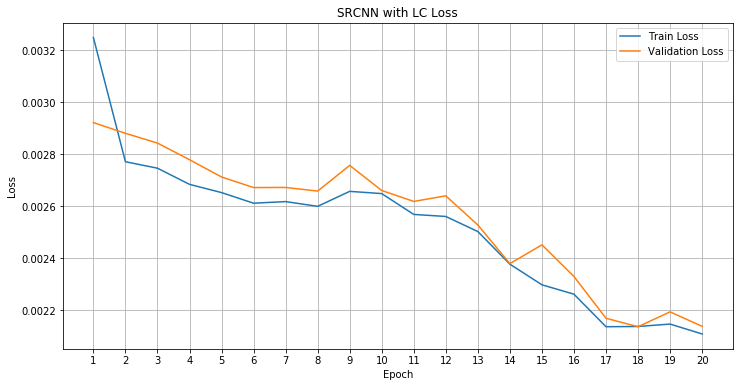

In [92]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Generate x-axis values starting from 1 to the length of the history data
epochs = range(1, len(history.history['loss']) + 1)

# Plot the training and validation loss metrics
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('SRCNN with LC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Set the x-axis ticks to be integer numbers
plt.xticks(epochs)

# Save the plot to a file
plt.savefig('srcnn_with_lc_loss.png', dpi=300, bbox_inches='tight')

plt.show()

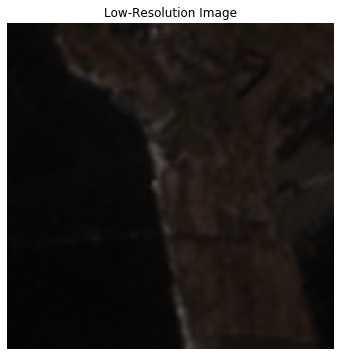

In [31]:
# Select a low-resolution image and enlarge it to the target size
lr_image_path = 'lr_images/Landcover-10236-L2A_data.tiff'
lr_image = preprocess_tiff(lr_image_path, target_size=(1054, 1054), normalize=False)

# Function to split an image into smaller patches
def split_image(image, size=(527, 527)):
    h, w = image.shape[:2]
    split_images = []
    for i in range(0, h, size[0]):
        for j in range(0, w, size[1]):
            split_img = image[i:i + size[0], j:j + size[1]]
            split_images.append(split_img)
    return split_images

# Split the enlarged low-resolution image into patches
lr_splits = split_image(lr_image)

# Select a patch for prediction
selected_lr_patch = lr_splits[2]

# Display the enlarged low-resolution image
plt.figure(figsize=(6, 6))
plt.imshow(selected_lr_patch)
plt.title('Low-Resolution Image')
plt.axis('off')
plt.show()

/home/zhou.hanyi/.local/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1/1 [==============================] - 0s 134ms/step


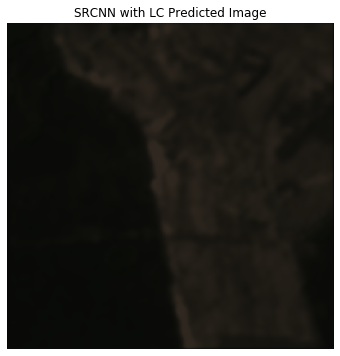

In [93]:
# Select a low-resolution image and enlarge it to the target size
lr_image_path = 'lr_images/Landcover-10236-L2A_data.tiff'
lr_image = preprocess_tiff(lr_image_path, target_size=(1054, 1054), normalize=True)

# Select the corresponding land cover (LC) image
lc_image_path = 'resized_lc_images/Landcover-10236_dynamic_world_label.tif'
with rasterio.open(lc_image_path) as src:
    lc_image = src.read(1)  # Read the single LC band
    lc_image = cv2.resize(lc_image, (1054, 1054), interpolation=cv2.INTER_CUBIC)
    lc_image = np.expand_dims(lc_image, axis=-1)  # Expand dimensions to match model input
    lc_image = np.clip(lc_image, 0, 255) / 255.0  # Normalize to 0-1 range

# Combine LR image with LC image to create a 4-channel input
lr_image_combined = np.concatenate((lr_image, lc_image), axis=-1)

# Split the combined low-resolution image into patches
lr_splits = split_image(lr_image_combined)

# Select a patch for prediction
selected_lr_patch = lr_splits[2]

# Predict using the model
predicted_patch = model.predict(np.expand_dims(selected_lr_patch, axis=0))[0]  # Add batch dimension

# Display the predicted patch
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(predicted_patch[:, :, :3], 0, 1))
plt.title('SRCNN with LC Predicted Image')
plt.axis('off')

# Save the plot to a file
plt.savefig('example_srcnn_with_lc_predicted_image.png', dpi=300, bbox_inches='tight')

plt.show()

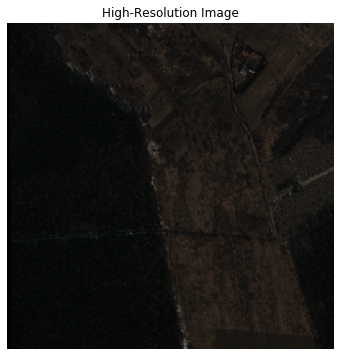

In [33]:
# Select the corresponding high-resolution image
hr_image_path = 'hr_images/Landcover-10236_rgb.png'
hr_image = load_image(hr_image_path, target_size=(1054, 1054), normalize=False)

# Split the enlarged low-resolution image into patches
hr_splits = split_image(hr_image)

selected_hr_patch = hr_splits[2]

# Display the enlarged low-resolution image
plt.figure(figsize=(6, 6))
plt.imshow(selected_hr_patch)
plt.title('High-Resolution Image')
plt.axis('off')
plt.show()

In [37]:
selected_hr_patch_normalized = selected_hr_patch / 255.0

# Calculate PSNR after normalization
psnr_example = psnr_metric(selected_hr_patch_normalized, predicted_patch_rgb)
print(f"PSNR for the selected patch: {psnr_example} dB")

PSNR for the selected patch: 33.14240264892578 dB


/home/zhou.hanyi/.local/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2/2 [==============================] - 3s 390ms/step


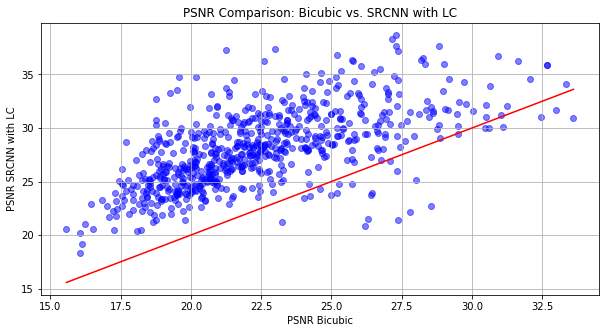

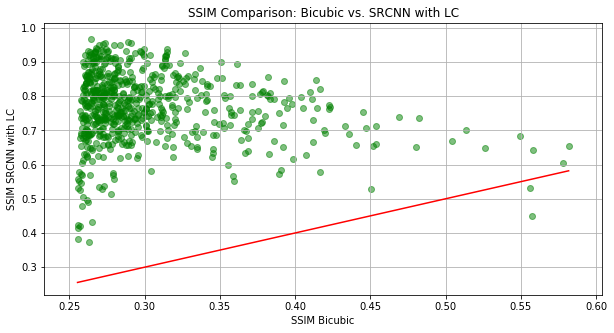

Average PSNR (Bicubic): 22.41 dB
Average PSNR (SRCNN with LC): 28.05 dB
Average SSIM (Bicubic): 0.3016
Average SSIM (SRCNN with LC): 0.7677


In [96]:
# Define PSNR and SSIM metrics with type conversion
def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)  # Convert to float64
    y_pred = tf.cast(y_pred, tf.float64)  # Convert to float64
    return tf.image.psnr(y_true, y_pred, max_val=1.0).numpy()

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)  # Convert to float64
    y_pred = tf.cast(y_pred, tf.float64)  # Convert to float64
    return tf.image.ssim(y_true, y_pred, max_val=1.0).numpy()

# Function to calculate PSNR and SSIM for all patches in the test set with LC input and save the results
def calculate_metrics_with_lc(test_generator, model):
    psnr_bicubic_list = []
    psnr_srcnn_list = []
    ssim_bicubic_list = []
    ssim_srcnn_list = []

    # Iterate over the test generator
    for lr_patches, hr_patches in test_generator:
        # Predict the HR patches using the model
        predicted_patches = model.predict(lr_patches)

        # Iterate over each patch
        for j in range(len(hr_patches)):
            # Calculate PSNR and SSIM for the bicubic interpolation (used as baseline)
            psnr_bicubic = psnr_metric(hr_patches[j], lr_patches[j])
            ssim_bicubic = ssim_metric(hr_patches[j], lr_patches[j])

            # Calculate PSNR and SSIM for the SRCNN predicted output
            psnr_srcnn = psnr_metric(hr_patches[j], predicted_patches[j])
            ssim_srcnn = ssim_metric(hr_patches[j], predicted_patches[j])

            # Append metrics to lists
            psnr_bicubic_list.append(psnr_bicubic)
            psnr_srcnn_list.append(psnr_srcnn)
            ssim_bicubic_list.append(ssim_bicubic)
            ssim_srcnn_list.append(ssim_srcnn)

    # Convert lists to numpy arrays
    psnr_bicubic_list = np.array(psnr_bicubic_list)
    psnr_srcnn_list = np.array(psnr_srcnn_list)
    ssim_bicubic_list = np.array(ssim_bicubic_list)
    ssim_srcnn_list = np.array(ssim_srcnn_list)

    # Save the results for later comparison
    np.save('psnr_with_lc.npy', psnr_srcnn_list)
    np.save('ssim_with_lc.npy', ssim_srcnn_list)

    # Calculate average metrics
    avg_psnr_bicubic = np.mean(psnr_bicubic_list)
    avg_psnr_srcnn = np.mean(psnr_srcnn_list)
    avg_ssim_bicubic = np.mean(ssim_bicubic_list)
    avg_ssim_srcnn = np.mean(ssim_srcnn_list)

    # Plot PSNR comparison
    plt.figure(figsize=(10, 5))
    plt.scatter(psnr_bicubic_list, psnr_srcnn_list, color='blue', alpha=0.5)
    plt.plot([psnr_bicubic_list.min(), psnr_bicubic_list.max()], [psnr_bicubic_list.min(), psnr_bicubic_list.max()], color='red')
    plt.xlabel('PSNR Bicubic')
    plt.ylabel('PSNR SRCNN with LC')
    plt.title('PSNR Comparison: Bicubic vs. SRCNN with LC')
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig('psnr_comparison_bicubic_vs_srcnn_with_lc.png', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Plot SSIM comparison
    plt.figure(figsize=(10, 5))
    plt.scatter(ssim_bicubic_list, ssim_srcnn_list, color='green', alpha=0.5)
    plt.plot([ssim_bicubic_list.min(), ssim_bicubic_list.max()], [ssim_bicubic_list.min(), ssim_bicubic_list.max()], color='red')
    plt.xlabel('SSIM Bicubic')
    plt.ylabel('SSIM SRCNN with LC')
    plt.title('SSIM Comparison: Bicubic vs. SRCNN with LC')
    plt.grid(True)
    
    # Save the plot to a file
    plt.savefig('ssim_comparison_bicubic_vs_srcnn_with_lc.png', dpi=300, bbox_inches='tight')
    
    plt.show()

    # Print average metrics
    print(f"Average PSNR (Bicubic): {avg_psnr_bicubic:.2f} dB")
    print(f"Average PSNR (SRCNN with LC): {avg_psnr_srcnn:.2f} dB")
    print(f"Average SSIM (Bicubic): {avg_ssim_bicubic:.4f}")
    print(f"Average SSIM (SRCNN with LC): {avg_ssim_srcnn:.4f}")

# Example usage
calculate_metrics_with_lc(test_generator, model)


In [67]:
# Load the saved results
psnr_baseline = np.load('psnr_baseline.npy')
ssim_baseline = np.load('ssim_baseline.npy')
psnr_with_lc = np.load('psnr_with_lc.npy')
ssim_with_lc = np.load('ssim_with_lc.npy')

In [68]:
print(f"PSNR Baseline size: {psnr_baseline.size}")
print(f"PSNR with LC size: {psnr_with_lc.size}")
print(f"SSIM Baseline size: {ssim_baseline.size}")
print(f"SSIM with LC size: {ssim_with_lc.size}")

PSNR Baseline size: 676
PSNR with LC size: 676
SSIM Baseline size: 676
SSIM with LC size: 676


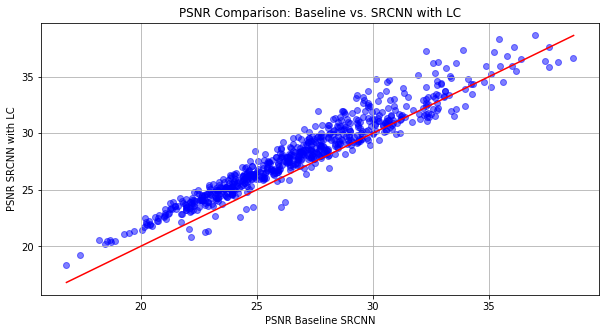

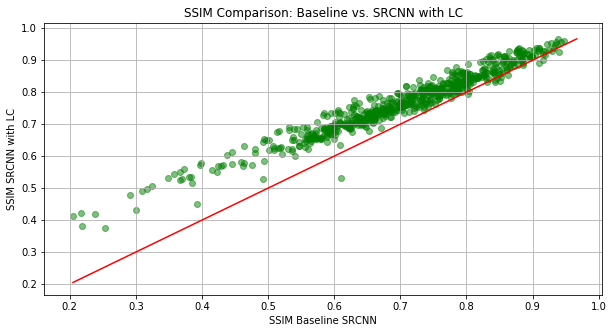

Average PSNR (Baseline): 26.83 dB
Average PSNR (SRCNN with LC): 28.05 dB
Average SSIM (Baseline): 0.7025
Average SSIM (SRCNN with LC): 0.7677


In [95]:
# Plot PSNR comparison between baseline and LC SRCNN
plt.figure(figsize=(10, 5))
plt.scatter(psnr_baseline, psnr_with_lc, color='blue', alpha=0.5)
plt.plot([min(psnr_baseline.min(), psnr_with_lc.min()), max(psnr_baseline.max(), psnr_with_lc.max())],
         [min(psnr_baseline.min(), psnr_with_lc.min()), max(psnr_baseline.max(), psnr_with_lc.max())], color='red')
plt.xlabel('PSNR Baseline SRCNN')
plt.ylabel('PSNR SRCNN with LC')
plt.title('PSNR Comparison: Baseline vs. SRCNN with LC')
plt.grid(True)

# Save the plot to a file
plt.savefig('psnr_comparison_baseline_vs_srcnn_with_lc.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot SSIM comparison between baseline and LC SRCNN
plt.figure(figsize=(10, 5))
plt.scatter(ssim_baseline, ssim_with_lc, color='green', alpha=0.5)
plt.plot([min(ssim_baseline.min(), ssim_with_lc.min()), max(ssim_baseline.max(), ssim_with_lc.max())],
         [min(ssim_baseline.min(), ssim_with_lc.min()), max(ssim_baseline.max(), ssim_with_lc.max())], color='red')
plt.xlabel('SSIM Baseline SRCNN')
plt.ylabel('SSIM SRCNN with LC')
plt.title('SSIM Comparison: Baseline vs. SRCNN with LC')
plt.grid(True)

# Save the plot to a file
plt.savefig('ssim_comparison_baseline_vs_srcnn_with_lc.png', dpi=300, bbox_inches='tight')

plt.show()

# Print average metrics comparison
print(f"Average PSNR (Baseline): {np.mean(psnr_baseline):.2f} dB")
print(f"Average PSNR (SRCNN with LC): {np.mean(psnr_with_lc):.2f} dB")
print(f"Average SSIM (Baseline): {np.mean(ssim_baseline):.4f}")
print(f"Average SSIM (SRCNN with LC): {np.mean(ssim_with_lc):.4f}")

In [74]:
import pandas as pd

# Lists to store indices of underperforming points
underperforming_psnr_indices = []
underperforming_ssim_indices = []

# Identify underperforming points for PSNR
for i, (psnr_base, psnr_lc) in enumerate(zip(psnr_baseline, psnr_with_lc)):
    if psnr_lc < psnr_base:
        underperforming_psnr_indices.append(i)

# Identify underperforming points for SSIM
for i, (ssim_base, ssim_lc) in enumerate(zip(ssim_baseline, ssim_with_lc)):
    if ssim_lc < ssim_base:
        underperforming_ssim_indices.append(i)

# Find the corresponding filenames for underperforming PSNR
underperforming_psnr_files = [hr_image_files[i] for i in underperforming_psnr_indices]

# Find the corresponding filenames for underperforming SSIM
underperforming_ssim_files = [hr_image_files[i] for i in underperforming_ssim_indices]

# Combine the lists to get all underperforming filenames (unique values only)
underperforming_filenames = list(set(underperforming_psnr_files + underperforming_ssim_files))

# Output the filenames
print("Underperforming PSNR Files:")
for file in underperforming_psnr_files:
    print(file)

print("\nUnderperforming SSIM Files:")
for file in underperforming_ssim_files:
    print(file)

Underperforming PSNR Files:
Landcover-10236_rgb.png
Landcover-1317815_rgb.png
Landcover-1663127_rgb.png
Landcover-1744069_rgb.png
Landcover-215461_rgb.png
Landcover-222743_rgb.png
Landcover-222927_rgb.png
Landcover-230632_rgb.png
Landcover-35500_rgb.png
Landcover-418264_rgb.png
Landcover-421719_rgb.png
Landcover-740603_rgb.png
Landcover-740664_rgb.png
Landcover-768922_rgb.png
Landcover-768927_rgb.png
Landcover-768955_rgb.png
Landcover-769259_rgb.png
Landcover-769296_rgb.png
Landcover-769361_rgb.png
Landcover-769387_rgb.png
Landcover-769629_rgb.png
Landcover-769662_rgb.png
Landcover-770516_rgb.png
Landcover-770797_rgb.png
Landcover-770845_rgb.png
Landcover-770884_rgb.png
Landcover-770919_rgb.png
Landcover-770920_rgb.png
Landcover-770954_rgb.png
Landcover-770989_rgb.png
Landcover-771042_rgb.png
Landcover-771443_rgb.png
Landcover-771477_rgb.png
Landcover-771557_rgb.png
Landcover-771794_rgb.png
Landcover-771819_rgb.png
Landcover-771837_rgb.png
Landcover-771889_rgb.png
Landcover-771892_rgb.

In [81]:
print(f"Number of underperforming files: {len(underperforming_filenames)}")

# Load the metadata CSV file without headers
metadata = pd.read_csv('metadata.csv', header=None)

# Extract Landcover IDs from the filenames
landcover_ids = [filename.split('_rgb.png')[0] for filename in underperforming_filenames]

# Find the corresponding IPCC classes by indexing the first column
underperforming_ipcc_classes = metadata[metadata[0].isin(landcover_ids)][12]

# Print the results
print("IPCC Classes for Underperforming Files:")
print(underperforming_ipcc_classes.value_counts() // 16)  # Count occurrences of each IPCC class

Number of underperforming files: 75
IPCC Classes for Underperforming Files:
Settlement     62
Agriculture     7
Forest          4
Other           2
Name: 12, dtype: int64


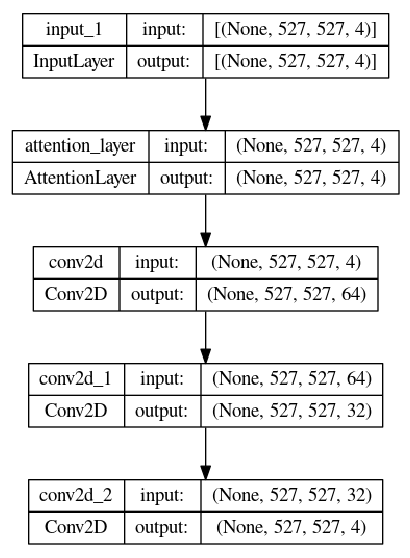

In [90]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='srcnn_with_lc_structure.png', show_shapes=True, show_layer_names=True)

# Display the model plot
img = plt.imread('srcnn_with_lc_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()